<a href="https://colab.research.google.com/github/mariron42/FisicaComputacional-1/blob/main/Evaluaci%C3%B3n/Examen1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Importamos las bibliotecas basicas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.arima_model import ARIMAResults



from statsmodels.tsa.stattools import acf, pacf# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [79]:
#Aquí preparamos nuestra DataFrame 
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_mlo_DailyData.txt'
#Analisasmos a estación de la antartida

#Le damos nombres a las columnas
my_cols = ['luger', 'year', 'month','day', 'hour', ' minute','second', ' time_n', 'value', ' nose', 'lol ','  lat','long', 'alti ', 'eleva', ' extra', ' ultimo']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos '-999.9' por espacio en blanco ''
str_Nulo = -999.99
df_work1 = df_work0.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['value']
for cols in cols_list:#para cada una de las columnas en la lista 
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()


df = pd.DataFrame({'day':df_work2['day'],'month':df_work2['month'], 'year':df_work2['year']})

df_work2['Fecha']=pd.to_datetime(df).copy()

 #Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
df_meteo = df_work2.copy()

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Vemos si nuestro data frame quedó bien imprimirendo infomación y primeros datos
df_meteo_ts.info()
print(df_meteo_ts.head())
print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_90 = df_meteo_ts[(df_meteo_ts['year'] >= 1980) & (df_meteo_ts['year'] < 2019)]

##########Eliminamos las columnas que no nos importan##########

df_90=df_90['value']

df_90.ffill(axis = 0, inplace=True)

df_90


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17166 entries, 1973-01-01 to 2019-12-31
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   luger    17166 non-null  object 
 1   year     17166 non-null  int64  
 2   month    17166 non-null  int64  
 3   day      17166 non-null  int64  
 4   hour     17166 non-null  int64  
 5    minute  17166 non-null  int64  
 6   second   17166 non-null  int64  
 7    time_n  17166 non-null  float64
 8   value    13936 non-null  float64
 9    nose    17166 non-null  float64
 10  lol      17166 non-null  int64  
 11    lat    17166 non-null  float64
 12  long     17166 non-null  float64
 13  alti     17166 non-null  float64
 14  eleva    17166 non-null  float64
 15   extra   17166 non-null  float64
 16   ultimo  17166 non-null  object 
dtypes: float64(8), int64(7), object(2)
memory usage: 2.4+ MB
           luger  year  month  day  ...   alti    eleva   extra   ultimo
Fecha            

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Fecha
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
               ...  
2018-12-27    409.02
2018-12-28    409.26
2018-12-29    408.90
2018-12-30    409.34
2018-12-31    409.65
Name: value, Length: 14245, dtype: float64

In [80]:
 #Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
 #Es una FUNCIÓN NO VA A EJECUTARSE EN CUANTO LE DES PLAY!!!

def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std()#ESTOS SON PROMEDIOS PARA UN AÑO 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='red',label='Original')
    plt.plot(rolmean, color='blue', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [81]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2013 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12'

ts_90 = df_90.loc[start:end].copy()#aquí es donde estamos creando el periodo de tiempo a analizar 


In [82]:
#Vemos los primeros datos 
ts_90.head()

Fecha
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
Name: value, dtype: float64

In [83]:
#vemos los ultimos datos 
ts_90.tail()

Fecha
2018-12-27    409.02
2018-12-28    409.26
2018-12-29    408.90
2018-12-30    409.34
2018-12-31    409.65
Name: value, dtype: float64

In [84]:
# Definimos la Serie de Tiempo con CO2 que vamos a estudiar, le damos un nombre genérico
ts_pruebat = ts_90.copy()

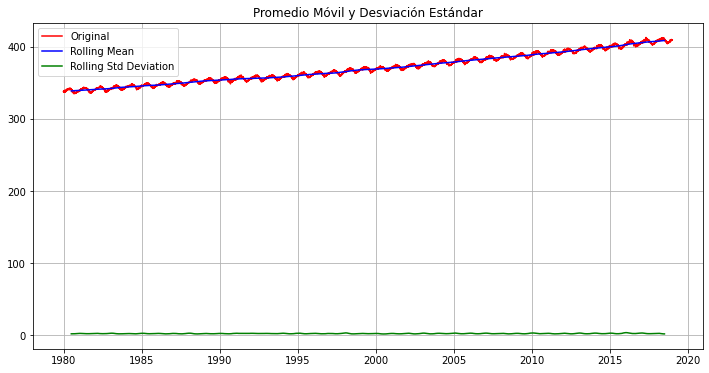

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.155189
p-value                            0.692569
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [85]:

# Realizamos la Prueba de Estacionaridad del c02

test_stationarity(ts_pruebat)#invocamos la función test_stationarity 

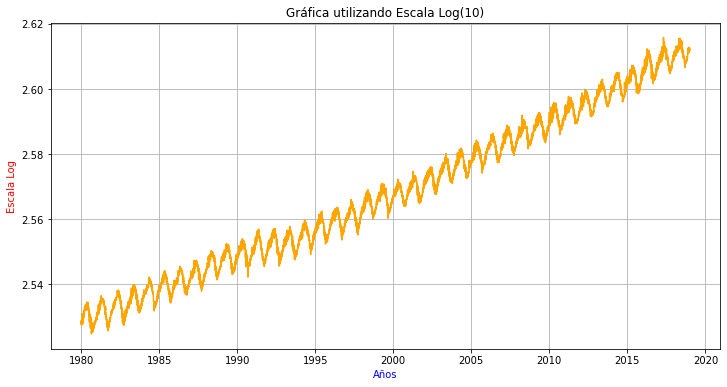

In [86]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)

ts_test_log = np.log10(ts_pruebat)#creamos la serie logaridmo
plt.plot(ts_test_log, color="orange")
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='red')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

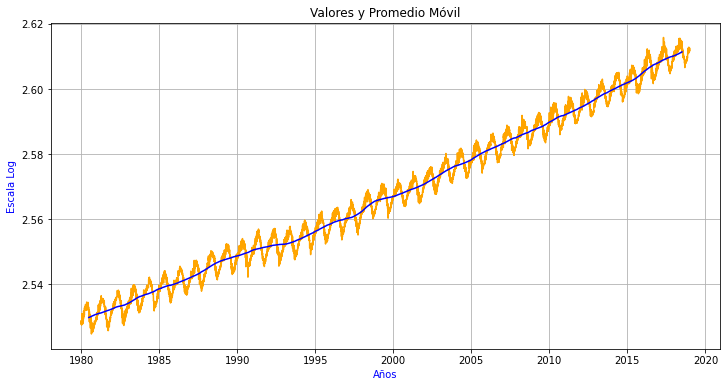

In [87]:
moving_avg = ts_test_log.rolling(365, center=True).mean()

plt.plot(ts_test_log,color="orange")
plt.plot(moving_avg, color = 'blue')#promedio movil
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [88]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: value, dtype: float64

In [89]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: value, dtype: float64

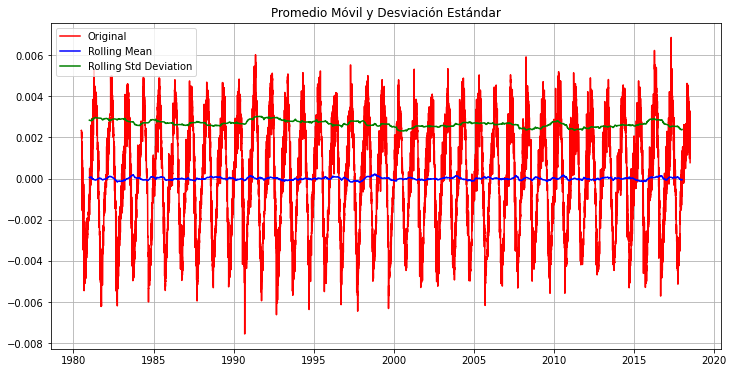

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.385363e+01
p-value                        6.931864e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [90]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
ts_test_log_moving_ave_diff.dropna(inplace=True)

test_stationarity(ts_test_log_moving_ave_diff)

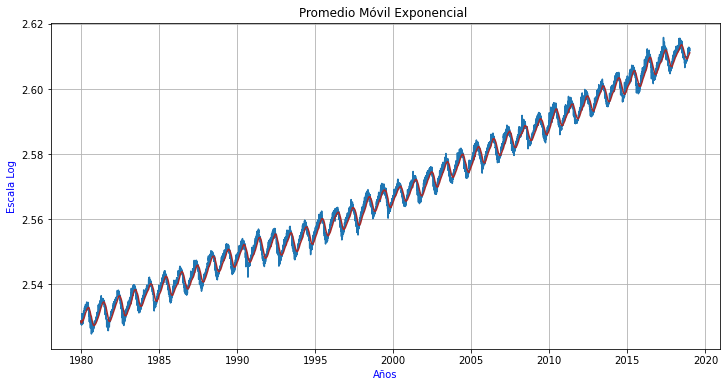

In [91]:

# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [92]:
EWM_avg.head()


Fecha
1980-01-01    2.528724
1980-01-02    2.528379
1980-01-03    2.528453
1980-01-04    2.528473
1980-01-05    2.528472
Name: value, dtype: float64

In [93]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

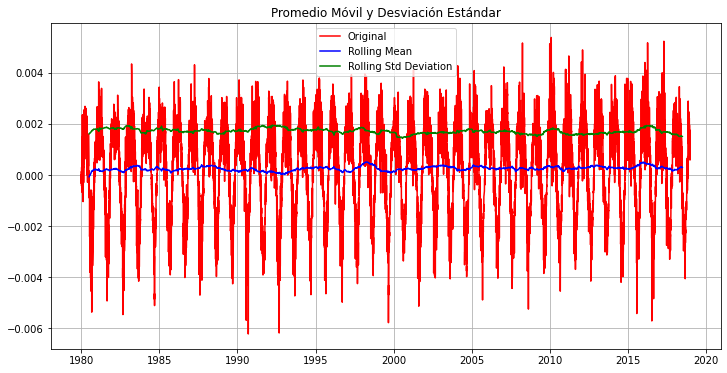

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.183178e+01
p-value                        7.959603e-22
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [94]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

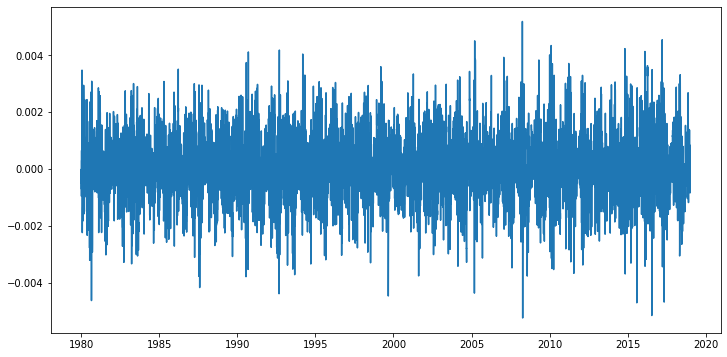

In [96]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

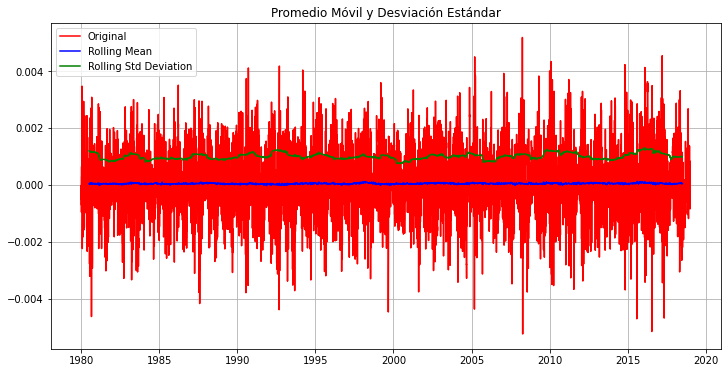

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.876005e+00
p-value                        3.881021e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [97]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [98]:
# Número de datos utilizados
len(ts_test_log_diff)

14238

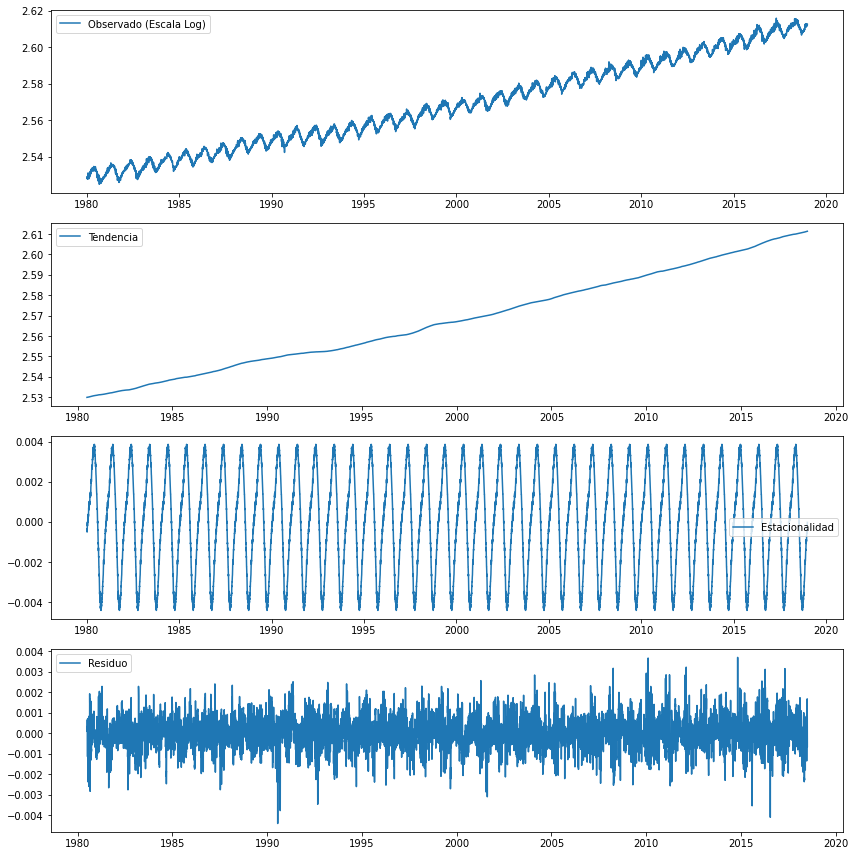

In [99]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

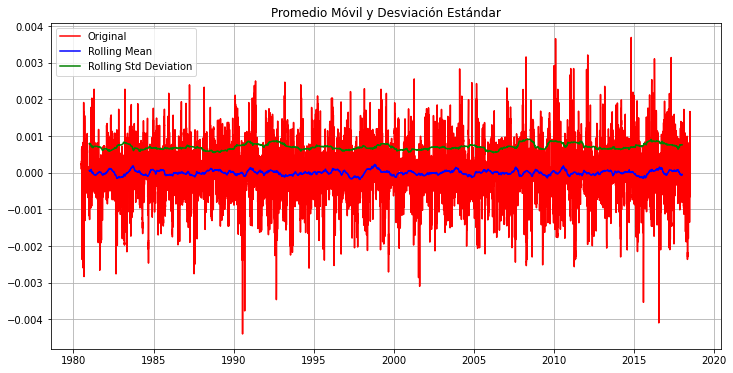

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.847383e+01
p-value                        2.137999e-30
#Lags Used                     2.200000e+01
Number of Observations Used    1.385800e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [100]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

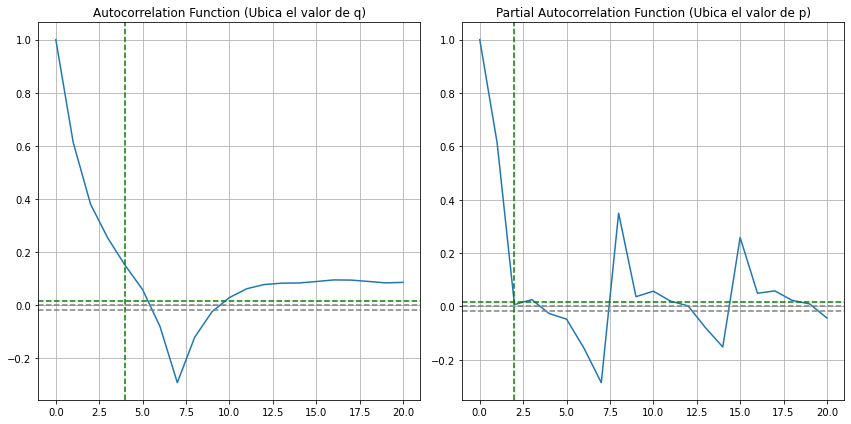

In [101]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Las líneas punteadas alrededor de cero representan los intervalos de confianza 

*   Elemento de lista
*   Elemento de lista

y nos serviran para determinar los valores p y q del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.

Con estos dos valores construiremos los modelos ARIMA correspondientes.
**Es raro que se parezcan a los valores del profe **

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood               85371.167
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -170734.334
Time:                        06:19:39   BIC                        -170704.077
Sample:                    01-02-1980   HQIC                       -170724.270
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06   3.53e-06      1.665      0.096   -1.04e-06    1.28e-05
ar.L1.D.value    -0.2427      0.008    -29.505      0.000      -0.259      -0.227
ar.L2.D.value    -0.1909      0.008    -

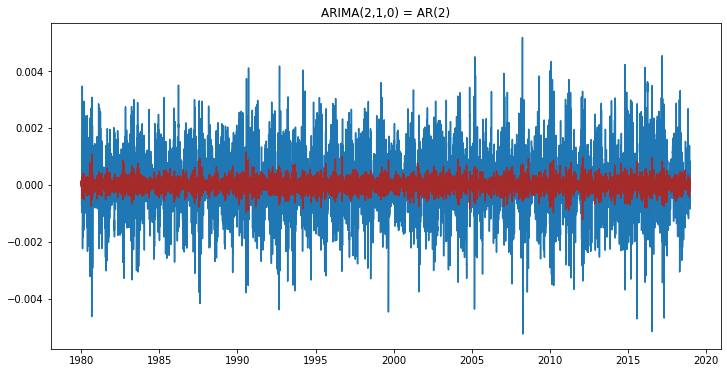

In [102]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(0, 1, 4)   Log Likelihood               85673.670
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171335.339
Time:                        06:19:44   BIC                        -171289.955
Sample:                    01-02-1980   HQIC                       -171320.243
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.874e-06   2.09e-06      2.815      0.005    1.78e-06    9.96e-06
ma.L1.D.value    -0.2999      0.008    -35.821      0.000      -0.316      -0.284
ma.L2.D.value    -0.1855      0.009    -

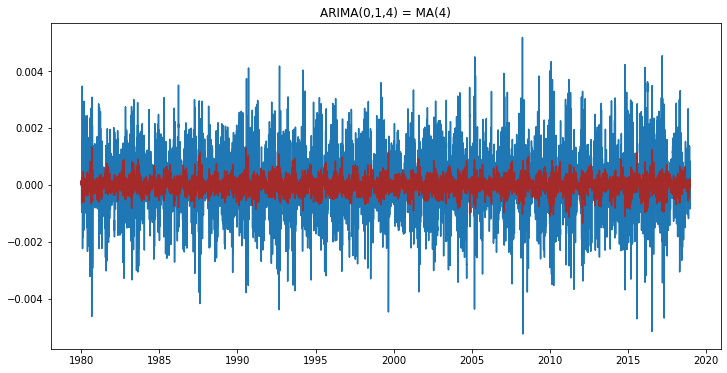

In [103]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14244
Model:                 ARIMA(2, 1, 4)   Log Likelihood               85660.038
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -171304.076
Time:                        06:07:01   BIC                        -171243.564
Sample:                    01-02-1980   HQIC                       -171283.948
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.872e-06   2.08e-06      2.822      0.005    1.79e-06    9.95e-06
ar.L1.D.value     0.3197        nan        nan        nan         nan         nan
ar.L2.D.value     0.2077        nan     

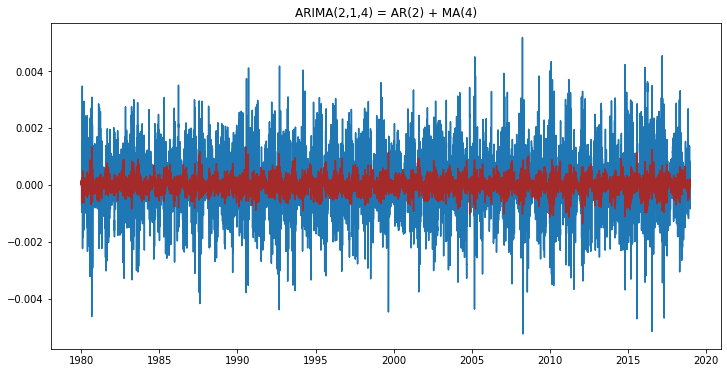

In [73]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


Importamos las bibliotecas a utilizar
[ ]
# Importamos las bibliotecas basicas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico

import statsmodels.api as sm
…import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


[ ]
for cols in cols_list:#para cada una de las columnas en la lista 
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

#convertimos los textos a datos de tiempo 
# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()
# Agregamos la opción de que el primer dato es el día (dayfirst=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23774 entries, 1944-02-01 to 2012-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  23736 non-null  float64
 1   Evap    20731 non-null  float64
 2   Tmax    23740 non-null  float64
 3   Tmin    23737 non-null  float64
 4   Año     23774 non-null  int64  
 5   Mes     23774 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
1944-02-01     0.0   1.2  23.7   4.8  1944  Feb
1944-02-02     0.0   1.2  24.6   5.7  1944  Feb
1944-02-03     0.0   2.8  21.8   7.4  1944  Feb
1944-02-04     0.0   2.1  21.4  11.9  1944  Feb
1944-02-05     0.0   2.2  21.2   8.4  1944  Feb
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
2012-12-27     0.0   3.3  17.6   8.0  2012  Dec
2012-12-28     0.0   2.6  17.8   5.0  2012  Dec
2012-12-29     0.0   2.1  18.0   3.5  2012  Dec
2012-12-30     0.5   1.6  16.4   3.5  2012  Dec
2012-12-31     0.0   2.0  16.4   4.0  2012  Dec
texto en negrita

[ ]
 #Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
 #Es una FUNCIÓN NO VA A EJECUTARSE EN CUANTO LE DES PLAY!!!

def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std()#ESTOS SON PROMEDIOS PARA UN AÑO 
    
    # Define el tamaño de la figura
…    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
[ ]

# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2013 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2000-01', '2011-12'

ts_90 = df_90.loc[start:end].copy()#aquí es donde estamos creando el periodo de tiempo a analizar 

[ ]
#Vemos los primeros datos 
ts_90.head()


[ ]
#vemos los ultimos datos 
ts_90.tail()


[ ]
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico
ts_pruebat = ts_90['Tmax'].copy()
[ ]

# Realizamos la Prueba de Estacionaridad de Tmax

test_stationarity(ts_pruebat)#invocamos la función test_stationarity 

[ ]
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_pruebat)#creamos la serie logaridmo
plt.plot(ts_test_log, color="orange")
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='red')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

[ ]

moving_avg = ts_test_log.rolling(365, center=True).mean()

plt.plot(ts_test_log,color="orange")
plt.plot(moving_avg, color = 'blue')#promedio movil
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

[ ]
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()
Fecha
2000-01-01   NaN
2000-01-02   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
Name: Tmax, dtype: float64
[ ]
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()
Fecha
2000-07-01    0.147990
2000-07-02    0.152970
2000-07-03    0.134787
2000-07-04    0.132414
2000-07-05    0.123745
Name: Tmax, dtype: float64
[ ]
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

[1]

# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

[ ]
EWM_avg.head()

Fecha
2000-01-01    1.342423
2000-01-02    1.342423
2000-01-03    1.311044
2000-01-04    1.296614
2000-01-05    1.297539
Name: Tmax, dtype: float64
[ ]
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg
[ ]
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

[ ]
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

[ ]
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

[ ]
# Número de datos utilizados
len(ts_test_log_diff)
4373
[ ]
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

…plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

[ ]
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

PRONOSTICAR DATO
[ ]
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
…
plt.tight_layout()

Las líneas punteadas alrededor de cero representan los intervalos de confianza

Elemento de lista
Elemento de lista
y nos serviran para determinar los valores p y q del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.

Con estos dos valores construiremos los modelos ARIMA correspondientes. *Es raro que se parezcan a los valores del profe *

[ ]
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

[ ]
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

[ ]
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

Bondad del ajuste Simplicidad del modelo o principio de parsimonia. Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -15379.594

ARIMA(0,1,4): AIC = -15619.194(valores falsos)

ARIMA(2,1,4): AIC = -15637.421 <- Es el menor AIC

Podemos afirmar que ARIMA(2,1,4) es el mejor modelo de los 3 que exploramos.

Último paso: Recolectando todo y regresando a la escala original.

Pasos a seguir:

Obtener los valores de la predicción y convertirlos en serie. Observaremos que falta un valor en el inicio (usamos shift=1). Luego convertir la diferenciación a escala logarímica

In [74]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    5.872468e-06
1980-01-03    1.481432e-04
1980-01-04    1.022983e-05
1980-01-05   -1.094065e-05
1980-01-06    1.437730e-05
                  ...     
2018-12-27    7.837248e-05
2018-12-28    1.778445e-04
2018-12-29    8.042208e-05
2018-12-30    1.603457e-04
2018-12-31    6.848297e-07
Length: 14244, dtype: float64


In [75]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.528048
1980-01-03    2.528744
1980-01-04    2.528541
1980-01-05    2.528456
dtype: float64
Fecha
2018-12-27    2.611823
2018-12-28    2.612177
2018-12-29    2.611698
2018-12-30    2.612245
2018-12-31    2.612414
dtype: float64


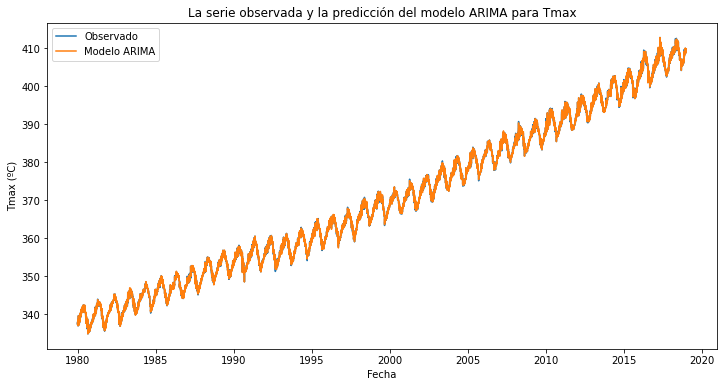

In [76]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_pruebat, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [77]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_pruebat)**2))
print('RMSE:', RMSE)

RMSE: 0.18422627564278338


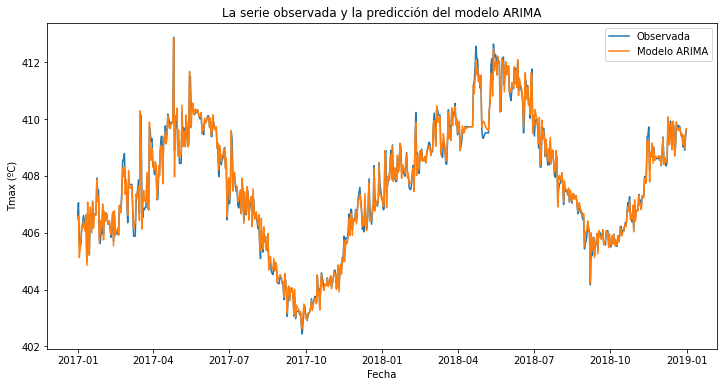

In [78]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_pruebat.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');